In [1]:
# Make thioformaldehyde (H2CS) cubes for inspection with DS9
from astroquery.splatalogue import Splatalogue
from spectral_cube import SpectralCube
from astropy import units as u
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage as nd

### Use Splatalogue to query H2CS lines in Bands 3 and 4, then Band 6 (observed)

In [2]:
tbl = Splatalogue.query_lines(85*u.GHz, 155*u.GHz, chemical_name=' H2CS ', line_lists=['JPL'],
                              energy_max=150, energy_type='eu_k', show_qn_code=True)
tbl.show_in_notebook()

idx,Species,Chemical Name,"Freq-GHz(rest frame,redshifted)","Freq Err(rest frame,redshifted)","Meas Freq-GHz(rest frame,redshifted)","Meas Freq Err(rest frame,redshifted)",Resolved QNs,CDMS/JPL Intensity,S<sub>ij</sub>&#956;<sup>2</sup> (D<sup>2</sup>),S<sub>ij</sub>,Log<sub>10</sub> (A<sub>ij</sub>),Lovas/AST Intensity,E_L (cm^-1),E_L (K),E_U (cm^-1),E_U (K),Quantum Number Code,Linelist
0,H2CS,Thioformaldehyde,--,--,101.47762,0.00012,"3(1,3)-2(1,2)",-3.6341,21.69902,7.98,-4.90073,0.49,12.5521,18.05957,15.93703,22.9297,303,JPL
1,H2CS,Thioformaldehyde,--,--,103.03999,0.0001,"3(2,2)-2(2,1)",-4.3594,4.52097,1.663,-5.08492,0.2,40.0668,57.64686,43.50384,62.59197,303,JPL
2,H2CS,Thioformaldehyde,--,--,103.04022,0.00015,"3(0,3)-2(0,2)",-4.0278,8.13836,2.993,-4.82961,0.2,3.4374,4.94562,6.87445,9.89075,303,JPL
3,H2CS,Thioformaldehyde,--,--,103.05181,0.00028,"3(2,1)-2(2,0)",-4.3593,4.52098,1.663,-5.08476,0.13,40.0669,57.647,43.50434,62.59268,303,JPL
4,H2CS,Thioformaldehyde,--,--,104.61704,7e-05,"3(1,2)-2(1,1)",-3.6079,21.70215,7.981,-4.86098,0.77,12.6568,18.21021,16.14645,23.231,303,JPL
5,H2CS,Thioformaldehyde,--,--,135.297811,0.00025,"4(1,4)-3(1,3)",-3.2444,30.5155,11.222,-4.48704,0.64,15.937,22.92966,20.45005,29.42289,303,JPL
6,H2CS,Thioformaldehyde,--,--,137.36917,0.00025,"4(3,2)-3(3,1)",-3.7147,14.24214,5.238,-4.79819,b,89.1451,128.25918,93.72724,134.85182,303,JPL
7,H2CS,Thioformaldehyde,--,--,137.36917,0.00025,"4(3,2)-3(3,1)",-3.7147,14.24214,5.238,-4.79819,b,89.1451,128.25918,93.72724,134.85182,303,JPL
8,H2CS,Thioformaldehyde,--,--,137.371051,0.0003,"4(0,4)-3(0,3)",-3.6615,10.84945,3.99,-4.43922,0.37,6.8745,9.89082,11.45671,16.48355,303,JPL
9,H2CS,Thioformaldehyde,--,--,137.382029,0.00032,"4(2,3)-3(2,2)",-3.8626,8.13826,2.993,-4.56399,0.10,43.5038,62.5919,48.08637,69.18516,303,JPL


In [3]:
tbl = Splatalogue.query_lines(239.9*u.GHz, 275*u.GHz, chemical_name=' H2CS ', line_lists=['JPL'], 
                              energy_max=150, energy_type='eu_k', show_qn_code=True)
tbl.show_in_notebook()

idx,Species,Chemical Name,"Freq-GHz(rest frame,redshifted)","Freq Err(rest frame,redshifted)","Meas Freq-GHz(rest frame,redshifted)","Meas Freq Err(rest frame,redshifted)",Resolved QNs,CDMS/JPL Intensity,S<sub>ij</sub>&#956;<sup>2</sup> (D<sup>2</sup>),S<sub>ij</sub>,Log<sub>10</sub> (A<sub>ij</sub>),Lovas/AST Intensity,E_L (cm^-1),E_L (K),E_U (cm^-1),E_U (K),Quantum Number Code,Linelist
0,H2CS,Thioformaldehyde,--,--,240.26632,0.0004,"7(0,7)-6(0,6)",-2.9722,18.98681,6.982,-3.68963,0.55,24.0546,34.609,32.06902,46.1399,303,JPL
1,H2CS,Thioformaldehyde,--,--,240.38175,0.00034,"7(2,6)-6(2,5)",-3.085,17.4397,6.414,-3.72591,0.16,60.6875,87.31527,68.70577,98.85171,303,JPL
2,H2CS,Thioformaldehyde,240.5482286,0.0001704,--,--,"7(2,5)-6(2,4)",-3.0845,17.43644,6.412,-3.72509,0.16,60.6945,87.32534,68.71833,98.86977,303,JPL
3,H2CS,Thioformaldehyde,--,--,244.04784,0.00059,"7(1,6)-6(1,5)",-2.5104,55.8065,20.523,-3.67817,0.91,33.5928,48.33227,41.73336,60.04465,303,JPL
4,H2CS,Thioformaldehyde,270.5207397,0.0003169,--,--,"8(1,8)-7(1,7)",-2.3767,64.08661,23.568,-3.53827,--,40.7563,58.63889,49.7799,71.62176,303,JPL
5,H2CS,Thioformaldehyde,274.5208698,0.0003318,--,--,"8(0,8)-7(0,7)",-2.8163,21.70009,7.98,-3.51233,--,32.069,46.13987,41.22603,59.31472,303,JPL
6,H2CS,Thioformaldehyde,274.7020548,0.0002753,--,--,"8(2,7)-7(2,6)",-2.9201,20.34243,7.481,-3.53953,--,68.7058,98.85175,77.86887,112.0353,303,JPL
7,H2CS,Thioformaldehyde,274.952473,0.0002755,--,--,"8(2,6)-7(2,5)",-2.9193,20.34446,7.482,-3.5383,--,68.7183,98.86974,77.88973,112.0653,303,JPL


### Extract cubes from around each of the lines we detect in mean spectra

In [4]:
results = '/blue/adamginsburg/abulatek/brick/symlinks/imaging_results/'
freq_spw = '137_spw69'
fn = results+'source_ab_'+freq_spw+'_clean_2sigma_n50000_masked_3sigma_pbmask0p18.image'
cube = SpectralCube.read(fn, format='casa_image')
h2cscube = cube.with_spectral_unit(u.km/u.s, velocity_convention='radio', 
                                   rest_value=137.371051*u.GHz).spectral_slab(-10*u.km/u.s, 80*u.km/u.s)
# h2cscube.write('H2CS_404-303.fits')

/blue/adamginsburg/abulatek/anaconda/lib/python3.7/site-packages/casa_formats_io-0.1-py3.7-linux-x86_64.egg/casa_formats_io/casa_dask.py:232: RuntimeWarning: divide by zero encountered in long_scalars
  factors = [f for f in range(stacks[dim] + 1) if stacks[dim] % f == 0]


In [5]:
results = '/blue/adamginsburg/abulatek/brick/symlinks/imaging_results/'
freq_spw = '102_spw29'
fn = results+'source_ab_'+freq_spw+'_clean_2sigma_n50000_masked_3sigma_pbmask0p18.image'
cube = SpectralCube.read(fn, format='casa_image')
h2cscube = cube.with_spectral_unit(u.km/u.s, velocity_convention='radio', 
                                   rest_value=103.04022*u.GHz).spectral_slab(-10*u.km/u.s, 80*u.km/u.s)
# h2cscube.write('H2CS_303-202.fits')

/blue/adamginsburg/abulatek/anaconda/lib/python3.7/site-packages/casa_formats_io-0.1-py3.7-linux-x86_64.egg/casa_formats_io/casa_dask.py:232: RuntimeWarning: divide by zero encountered in long_scalars
  factors = [f for f in range(stacks[dim] + 1) if stacks[dim] % f == 0]


In [6]:
results = '/blue/adamginsburg/abulatek/brick/symlinks/imaging_results/'
freq_spw = '102_spw23'
fn = results+'source_ab_'+freq_spw+'_clean_2sigma_n50000_masked_3sigma_pbmask0p18.image'
cube = SpectralCube.read(fn, format='casa_image')
h2cscube = cube.with_spectral_unit(u.km/u.s, velocity_convention='radio', 
                                   rest_value=101.47762*u.GHz).spectral_slab(-10*u.km/u.s, 80*u.km/u.s)
# h2cscube.write('H2CS_313-212.fits')

/blue/adamginsburg/abulatek/anaconda/lib/python3.7/site-packages/casa_formats_io-0.1-py3.7-linux-x86_64.egg/casa_formats_io/casa_dask.py:232: RuntimeWarning: divide by zero encountered in long_scalars
  factors = [f for f in range(stacks[dim] + 1) if stacks[dim] % f == 0]


In [7]:
results = '/blue/adamginsburg/abulatek/brick/symlinks/imaging_results/'
freq_spw = '103_spw31'
fn = results+'source_ab_'+freq_spw+'_clean_2sigma_n50000_masked_3sigma_pbmask0p18.image'
cube = SpectralCube.read(fn, format='casa_image')
h2cscube = cube.with_spectral_unit(u.km/u.s, velocity_convention='radio', 
                                   rest_value=104.61704*u.GHz).spectral_slab(-10*u.km/u.s, 80*u.km/u.s)
# h2cscube.write('H2CS_312-211.fits')

/blue/adamginsburg/abulatek/anaconda/lib/python3.7/site-packages/casa_formats_io-0.1-py3.7-linux-x86_64.egg/casa_formats_io/casa_dask.py:232: RuntimeWarning: divide by zero encountered in long_scalars
  factors = [f for f in range(stacks[dim] + 1) if stacks[dim] % f == 0]


In [8]:
results = '/blue/adamginsburg/abulatek/brick/symlinks/imaging_results/'
freq_spw = '135_spw47'
fn = results+'source_ab_'+freq_spw+'_clean_2sigma_n50000_masked_3sigma_pbmask0p18.image'
cube = SpectralCube.read(fn, format='casa_image')
h2cscube = cube.with_spectral_unit(u.km/u.s, velocity_convention='radio', 
                                   rest_value=135.297811*u.GHz).spectral_slab(-10*u.km/u.s, 80*u.km/u.s)
# h2cscube.write('H2CS_414-313.fits')

/blue/adamginsburg/abulatek/anaconda/lib/python3.7/site-packages/casa_formats_io-0.1-py3.7-linux-x86_64.egg/casa_formats_io/casa_dask.py:232: RuntimeWarning: divide by zero encountered in long_scalars
  factors = [f for f in range(stacks[dim] + 1) if stacks[dim] % f == 0]


In [9]:
results = '/blue/adamginsburg/abulatek/brick/symlinks/imaging_results/'
freq_spw = '139_spw71'
fn = results+'source_ab_'+freq_spw+'_clean_2sigma_n50000_masked_3sigma_pbmask0p18.image'
cube = SpectralCube.read(fn, format='casa_image')
h2cscube = cube.with_spectral_unit(u.km/u.s, velocity_convention='radio', 
                                   rest_value=139.48341*u.GHz).spectral_slab(-10*u.km/u.s, 80*u.km/u.s)
# h2cscube.write('H2CS_413-312.fits')

/blue/adamginsburg/abulatek/anaconda/lib/python3.7/site-packages/casa_formats_io-0.1-py3.7-linux-x86_64.egg/casa_formats_io/casa_dask.py:232: RuntimeWarning: divide by zero encountered in long_scalars
  factors = [f for f in range(stacks[dim] + 1) if stacks[dim] % f == 0]


### Do one for NH2D

In [10]:
tbl = Splatalogue.query_lines(80*u.GHz, 90*u.GHz, chemical_name=' NH2D ', line_lists=['JPL'], 
                              energy_max=150, energy_type='eu_k', show_qn_code=True)
tbl.show_in_notebook()

idx,Species,Chemical Name,"Freq-GHz(rest frame,redshifted)","Freq Err(rest frame,redshifted)","Meas Freq-GHz(rest frame,redshifted)","Meas Freq Err(rest frame,redshifted)",Resolved QNs,CDMS/JPL Intensity,S<sub>ij</sub>&#956;<sup>2</sup> (D<sup>2</sup>),S<sub>ij</sub>,Log<sub>10</sub> (A<sub>ij</sub>),Lovas/AST Intensity,E_L (cm^-1),E_L (K),E_U (cm^-1),E_U (K),Quantum Number Code,Linelist
0,NH2D,Ammonia,--,--,85.9247829,1e-05,"1(1,1)0s-1(0,1)0a,F=0-1",-4.4119,3.1778,0.0,-4.62958,--,11.5063,16.5549,14.37244,20.67862,1405,JPL
1,NH2D,Ammonia,--,--,85.9257031,1e-05,"1(1,1)0s-1(0,1)0a,F=2-1",-4.315,3.97208,0.0,-5.23165,--,11.5063,16.5549,14.37247,20.67866,1405,JPL
2,NH2D,Ammonia,--,--,85.9262703,1e-05,"1(1,1)0s-1(0,1)0a,F=2-2",-3.8379,11.91549,0.0,-4.75455,--,11.5063,16.5549,14.37249,20.67869,1405,JPL
3,NH2D,Ammonia,--,--,85.9263165,1e-05,"1(1,1)0s-1(0,1)0a,F=1-1",-4.5369,2.38293,0.0,-5.2317,--,11.5063,16.5549,14.37249,20.67869,1405,JPL
4,NH2D,Ammonia,--,--,85.9268837,1e-05,"1(1,1)0s-1(0,1)0a,F=1-2",-4.315,3.97197,0.0,-5.00979,--,11.5063,16.5549,14.37251,20.67872,1405,JPL
5,NH2D,Ammonia,--,--,85.9277345,1e-05,"1(1,1)0s-1(0,1)0a,F=1-0",-4.4119,3.17758,0.0,-5.10669,--,11.5063,16.5549,14.37254,20.67876,1405,JPL


In [11]:
results = '/blue/adamginsburg/abulatek/brick/symlinks/imaging_results/'
freq_spw = '87_spw25'
fn = results+'source_ab_'+freq_spw+'_clean_2sigma_n50000_masked_3sigma_pbmask0p18.image'
cube = SpectralCube.read(fn, format='casa_image')
nh2dcube = cube.with_spectral_unit(u.km/u.s, velocity_convention='radio', 
                                   rest_value=85.9247829*u.GHz).spectral_slab(-10*u.km/u.s, 80*u.km/u.s)
# nh2dcube.write('NH2D_hyperfine.fits')

/blue/adamginsburg/abulatek/anaconda/lib/python3.7/site-packages/casa_formats_io-0.1-py3.7-linux-x86_64.egg/casa_formats_io/casa_dask.py:232: RuntimeWarning: divide by zero encountered in long_scalars
  factors = [f for f in range(stacks[dim] + 1) if stacks[dim] % f == 0]


### Make moment maps out of each of these subcubes

In [12]:
def get_noise_map(cube_noise):
    cube_sclip = cube_noise.sigma_clip_spectrally(3) # Clip values above 3-sigma 
    mad_std_spectrum_sclip = cube_sclip.mad_std(axis=(1, 2))
    plt.plot(mad_std_spectrum_sclip.spectral_axis.value, mad_std_spectrum_sclip.value, 
             drawstyle='steps-mid')
    plt.xlabel('Velocity (km/s)')
    plt.ylabel(r' Noise standard deviation $\sigma$ (K)')
#     plt.ylim([0., 0.30]) # Best to extend the range to 0.
#     plt.axhline(0.25, linestyle='--', color='k', linewidth=3, label='A priori noise expectation')
    plt.legend(frameon=True)
    cube_sclip_slice = cube_sclip.spectral_slab(50*u.km/u.s, 80*u.km/u.s)
    mad_std_map_sclip = cube_sclip.mad_std(axis=0) # Calculate sigma along the spectral dimension
    return mad_std_map_sclip

def get_signal_mask_scipy(cube_signal, mad_std_map_sclip):
    '''Please pass an already-masked cube to cube_signal'''
    # Make a low and high mask
    low_snr_mask = (cube_signal > 3 * mad_std_map_sclip).include()
    high_snr_mask = (cube_signal > 10 * mad_std_map_sclip).include()
    low_snr_mask = low_snr_mask.compute() # We need to convert from a dask array to a numpy array.
    high_snr_mask = high_snr_mask.compute()
    # Find connected structures
    structure = np.ones((3, 3, 3), dtype=bool)
    low_snr_mask_labels, num_labels = nd.label(low_snr_mask, structure=structure)
    print(f"Initial number of regions found: {num_labels}")
    # From the labels, count the number of pixels within each label.
    num_pixels_in_high_snr_mask = nd.sum(high_snr_mask,
                                         labels=low_snr_mask_labels,
                                         index=range(1, num_labels + 1)) # +1 offset for mask labels
    # Repeat for the high signal mask.
    num_pixels_in_low_snr_mask = nd.sum(low_snr_mask,
                                        labels=low_snr_mask_labels,
                                        index=range(1, num_labels + 1)) # +1 offset for mask labels
    # To preserve the low_snr_mask, we will create a new signal mask where we will remove 
    # regions that do not pass the criteria.
    signal_mask = low_snr_mask
    low_min_pixels = 40
    high_min_pixels = 10
    for num, (high_pix_num, low_pix_num) in enumerate(zip(num_pixels_in_high_snr_mask, 
                                                          num_pixels_in_low_snr_mask)):
        if high_pix_num >= high_min_pixels and low_pix_num >= low_min_pixels:
            # This region passes the criteria. Keep it in the mask.
            continue
        # Remove regions that do not pass the criteria.
        # NOTE: enumerate will start with 0, but the mask labels start at 1
        # We apply a +1 offset to `num` to account for this.
        signal_mask[low_snr_mask_labels == num + 1] = False
    signal_mask_labels, num_labels = nd.label(signal_mask,
                                              structure=structure)
    print(f"Final number of regions found: {num_labels}")
    signal_mask = nd.binary_dilation(signal_mask, structure=structure, iterations=1)
    return signal_mask

In [13]:
# Get overall cube
cube = SpectralCube.read('H2CS_414-313.fits', use_dask=True)
cube

DaskVaryingResolutionSpectralCube with shape=(85, 512, 512) and unit=Jy / beam and chunk size (85, 512, 512):
 n_x:    512  type_x: RA---SIN  unit_x: deg    range:   266.528130 deg:  266.560501 deg
 n_y:    512  type_y: DEC--SIN  unit_y: deg    range:   -28.719152 deg:  -28.690763 deg
 n_s:     85  type_s: VRAD      unit_s: km / s  range:      -10.425 km / s:      80.460 km / s

In [14]:
subcube_low = cube.spectral_slab(-10*u.km/u.s, 25*u.km/u.s)
subcube_high = cube.spectral_slab(25*u.km/u.s, 50*u.km/u.s)

No handles with labels found to put in legend.
No handles with labels found to put in legend.


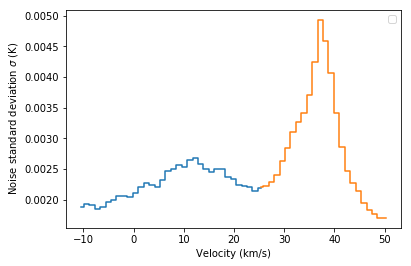

In [15]:
# Get noise map
mad_std_map_sclip_low = get_noise_map(subcube_low)
mad_std_map_sclip_high = get_noise_map(subcube_high)

In [16]:
plain_mask_low = subcube_low >= 3 * mad_std_map_sclip_low
plain_masked_slab_low = subcube_low.with_mask(plain_mask_low)
plain_mask_high = subcube_high >= 3 * mad_std_map_sclip_high
plain_masked_slab_high = subcube_high.with_mask(plain_mask_high)

In [17]:
signal_mask_low = get_signal_mask_scipy(plain_masked_slab_low, mad_std_map_sclip_low)
masked_cube_low = plain_masked_slab_low.with_mask(signal_mask_low)
signal_mask_high = get_signal_mask_scipy(plain_masked_slab_high, mad_std_map_sclip_high)
masked_cube_high = plain_masked_slab_high.with_mask(signal_mask_high)

Initial number of regions found: 1280
Final number of regions found: 6
Initial number of regions found: 1117
Final number of regions found: 6


In [18]:
# masked_moment0 = masked_cube.moment0() # masked_cubes[n]

# ax = plt.subplot(projection=masked_moment0.wcs)
# im = ax.imshow(masked_moment0.value, origin='lower', cmap='inferno')
# cbar = plt.colorbar(im)
# cbar.set_label('Integrated Intensity (K km/s)')
# ax.set_ylabel('Declination')
# ax.set_xlabel('Right Ascension')

In [19]:
# masked_moment1 = masked_cube.moment1() # masked_cubes[n]

# ax = plt.subplot(projection=masked_moment1.wcs)
# im = ax.imshow(masked_moment1.value, origin='lower', cmap='coolwarm')
# cbar = plt.colorbar(im)
# cbar.set_label('Centroid (km/s)')

# ax.set_ylabel('Declination')
# ax.set_xlabel('Right Ascension')

In [20]:
# from astroquery.splatalogue import Splatalogue
# from astropy import units as u
# from spectral_cube import SpectralCube
# results = '/blue/adamginsburg/abulatek/brick/symlinks/imaging_results/'
# tbl = Splatalogue.query_lines(109*u.GHz, 111*u.GHz, chemical_name=' NH2D ', line_lists=['JPL'],
#                               energy_max=150, energy_type='eu_k', show_qn_code=True)
# tbl

#### testing nh2d spectrum to compare with recent paper

In [21]:
# freq_spw = '110_spw29'
# fn = results+'source_ab_'+freq_spw+'_clean_2sigma_n50000_masked_3sigma_pbmask0p18.image'
# cube = SpectralCube.read(fn, format='casa_image')
# cube = cube.with_spectral_unit(u.km/u.s, velocity_convention='radio', 
#                                    rest_value=110.1536299*u.GHz).spectral_slab(-10*u.km/u.s, 80*u.km/u.s)
# # cube.write('test_nh2d.fits')

In [22]:
# cube = SpectralCube.read('test_nh2d.fits')
# cube.max(axis=0).quicklook()

In [23]:
# # plt.plot(cube.max(axis=0)) # this is not right but it does look cool
# mxspec = cube.max(axis=(1,2))

In [24]:
# import pylab as pl
# import pyspeckit
# kspectrum_ps = pyspeckit.Spectrum(xarr = mxspec.spectral_axis, data = mxspec.value)

# Make a figure that includes the mom0 maps and PV projections for each of the two velocity components

In [25]:
# Let's get masked moment maps for each of the cubes
masked_moment0_low = masked_cube_low.moment0()
masked_moment0_high = masked_cube_high.moment0()
mom0s = [masked_moment0_low, masked_moment0_high]

/blue/adamginsburg/abulatek/anaconda/lib/python3.7/site-packages/radio_beam-0.3.3-py3.7.egg/radio_beam/multiple_beams.py:265: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/blue/adamginsburg/abulatek/anaconda/lib/python3.7/site-packages/radio_beam-0.3.3-py3.7.egg/radio_beam/multiple_beams.py:265: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"


In [26]:
masked_cube_low.with_spectral_unit(u.km/u.s)

DaskVaryingResolutionSpectralCube with shape=(34, 512, 512) and unit=Jy / beam and chunk size (34, 512, 512):
 n_x:    512  type_x: RA---SIN  unit_x: deg    range:   266.528130 deg:  266.560501 deg
 n_y:    512  type_y: DEC--SIN  unit_y: deg    range:   -28.719152 deg:  -28.690763 deg
 n_s:     34  type_s: VRAD      unit_s: km / s  range:      -10.425 km / s:      25.280 km / s

In [27]:
collapse1_low = masked_cube_low.with_spectral_unit(u.km/u.s).mean(axis = 1) # Collapse along one spatial axis
collapse2_low = masked_cube_low.with_spectral_unit(u.km/u.s).mean(axis = 2) # Collapse along the other spatial axis
collapse1_high = masked_cube_high.with_spectral_unit(u.km/u.s).mean(axis = 1) # Collapse along one spatial axis
collapse2_high = masked_cube_high.with_spectral_unit(u.km/u.s).mean(axis = 2) # Collapse along the other spatial axis
collapse1s = [collapse1_low, collapse1_high]
collapse2s = [collapse2_low, collapse2_high]

### This is now the version I'm using as of 7/14 morning! H2CS maps/PV projections

In [32]:
# collapse1.wcs

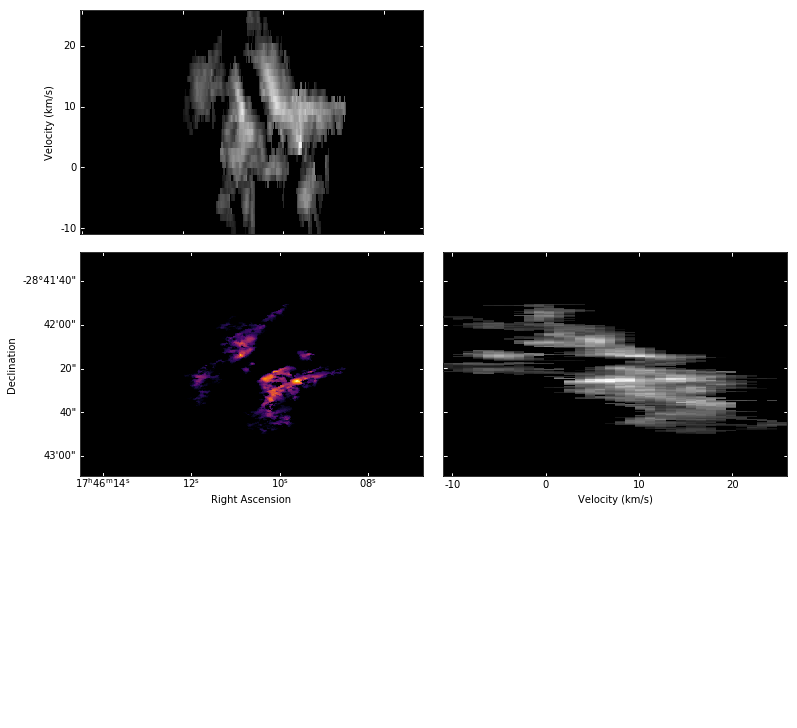

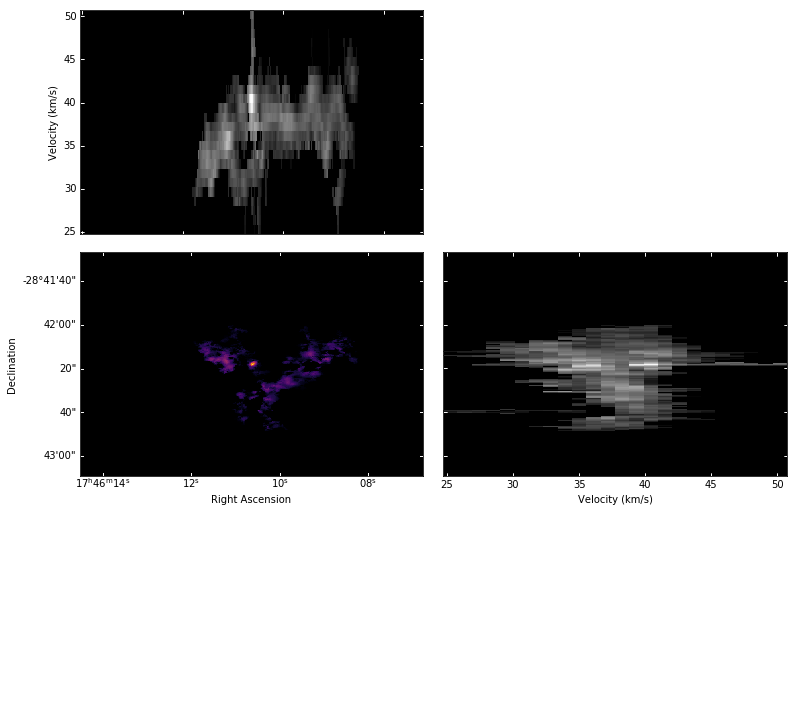

In [36]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

i = 0
for i in range(len(mom0s)):
    masked_moment0 = mom0s[i]
    collapse1 = collapse1s[i]
    collapse2 = collapse2s[i]
    if i == 0:
        plot_type = 'Low'
    elif i == 1:
        plot_type = 'High'
    
    # Initalize figure
    fig = plt.figure(figsize = (10, 10), constrained_layout=True)
    
    # Plot moment 0 map
    ax1 = plt.subplot(323, projection = masked_moment0.wcs)
    ax1.set_aspect(1.)
    im1 = ax1.imshow(masked_moment0.value, origin='lower', cmap='inferno', aspect='auto')
    ax1.set_ylabel('Declination')
    ax1.set_xlabel('Right Ascension')
#     plt.title(f'H2CS $4(1, 4)-3(1, 3)$ Moment 0 Map ({plot_type} Velocity)')
    ax1.tick_params(direction='in', color='#FFFFFF')
    ax1.set_facecolor('#000000')
    
#     cax = plt.subplot(325)
#     cbar = plt.colorbar(im1, cax = cax, orientation = 'horizontal')
#     cbar.set_label('Integrated Intensity (K km/s)')

    # Plot PV projection along one spatial axis (TOP LEFT)
#     ax2 = divider.append_axes("top", size="5%", axes_class = ax1.Axes)
    ax2 = plt.subplot(321, projection = collapse1.wcs, sharex = ax1)
#     ax2 = plt.subplot(321, sharex = ax1)
    im2 = ax2.imshow(collapse1.value, origin='lower', cmap='gray', aspect='auto')
    ax2.coords[1].set_format_unit(u.km / u.s)
    ax2.set_ylabel('Velocity (km/s)')
    ax2.coords[0].set_ticklabel_visible(False)
    ax2.tick_params(direction='in', color='#FFFFFF')
    ax2.set_facecolor('#000000')

    # Plot PV projection along the other spatial axis (BOTTOM RIGHT)
#     ax3 = divider.append_axes("right", size="5%", axes_class = ax1.Axes)
    ax3 = plt.subplot(324, projection = collapse2.wcs.sub([2,1]), sharey = ax1)
    im3 = ax3.imshow(collapse2.T.value, origin='lower', cmap='gray', aspect='auto')
    ax3.coords[0].set_format_unit(u.km / u.s)
    ax3.set_xlabel('Velocity (km/s)')
    ax3.coords[1].set_ticklabel_visible(False)
    ax3.tick_params(direction='in', color='#FFFFFF')
    ax3.set_facecolor('#000000')
    
    # Trying to remove axis labels
#     plt.setp(ax3.get_yticklabels(), visible=False) # This didn't remove anything
#     ax3.get_yaxis().set_visible(False) # This also didn't remove anything
#     ax3.yaxis.set_visible(False) # Also does nothing
#     plt.axis('off') # Not what I want, but works

    # Checking axes
#     print(f"Moment map x limits: {ax1.get_xlim()}")
#     print(f"Upper PV projection x limits: {ax2.get_xlim()}")
#     print(f"Right PV projection x limits: {ax3.get_xlim()}")
#     print(f"Moment map y limits: {ax1.get_ylim()}")
#     print(f"Upper PV projection y limits: {ax2.get_ylim()}")
#     print(f"Right PV projection y limits: {ax3.get_ylim()}")

    # plt.savefig(f'/blue/adamginsburg/abulatek/brick/first_results/lineID/plots/unlabeled/{freq_spw}.pdf', bbox_inches='tight')
    plt.show()
    i += 1

### Attempt 2 at plot

In [28]:
# # STILL NEED TO:
# # Match coordinate axes
# # Switch axis numbers and labels for PV over RA
# # Make plot labels nice

# i = 0
# for i in range(len(mom0s)):
#     masked_moment0 = mom0s[i]
#     collapse1 = collapse1s[i]
#     collapse2 = collapse2s[i]
#     if i == 0:
#         plot_type = 'Low'
#     elif i == 1:
#         plot_type = 'High'
    
#     # Initalize figure
# #     plt.subplots(2, 2, figsize = (10, 10), sharex='col', sharey='row')
#     fig = plt.figure(figsize = (10, 10)) # tight_layout = True
    
#     # Plot moment 0 map
#     ax1 = fig.add_subplot(2, 2, 3, projection = masked_moment0.wcs)
#     im1 = plt.imshow(masked_moment0.value, origin='lower',  cmap='inferno')
#     ax1.set_ylabel('Declination')
#     ax1.set_xlabel('Right Ascension')
#     plt.title(f'H2CS $4(1, 4)-3(1, 3)$ Moment 0 Map ({plot_type} Velocity)')

#     # Plot PV projection along one spatial axis
#     ax2 = fig.add_subplot(2, 2, 1, projection = collapse1.wcs, sharex = ax1)
#     im2 = plt.imshow(collapse1.value, origin='lower',  cmap='inferno', aspect='auto') # aspect='auto'
# #     ax2.set_ylabel('Velocity')
# #     ax2.set_xlabel('Right Ascension')
# #     ax2.set_xticks(ax1.get_xticks())
# #     ax2.set_xticklabels(ax1.get_xticklabels())
#     plt.title('Position-velocity projection along dec')

#     # Plot PV projection along the other spatial axis
#     ax3 = fig.add_subplot(2, 2, 4, projection = collapse2.T.wcs, sharey = ax1)
#     im3 = plt.imshow(collapse2.T.value, origin='lower', cmap='inferno', aspect='auto')
# #     ax3.set_ylabel('Velocity')
# #     ax3.set_xlabel('Declination')
#     plt.title('Position-velocity projection along RA')

#     cbar = plt.colorbar(im1)
#     cbar.set_label('Integrated Intensity (K km/s)')

#     # plt.savefig(f'/blue/adamginsburg/abulatek/brick/first_results/lineID/plots/unlabeled/{freq_spw}.pdf')
#     plt.show()
#     i += 1

# Do allll that again for NH2D

In [29]:
# Get overall cube
cube = SpectralCube.read('NH2D_hyperfine.fits', use_dask=True)
cube

DaskVaryingResolutionSpectralCube with shape=(27, 512, 512) and unit=Jy / beam and chunk size (27, 512, 512):
 n_x:    512  type_x: RA---SIN  unit_x: deg    range:   266.528130 deg:  266.560501 deg
 n_y:    512  type_y: DEC--SIN  unit_y: deg    range:   -28.719152 deg:  -28.690763 deg
 n_s:     27  type_s: VRAD      unit_s: km / s  range:       -9.493 km / s:      79.083 km / s

In [30]:
subcube_low = cube.spectral_slab(-10*u.km/u.s, 25*u.km/u.s)
subcube_high = cube.spectral_slab(25*u.km/u.s, 50*u.km/u.s)

No handles with labels found to put in legend.
No handles with labels found to put in legend.


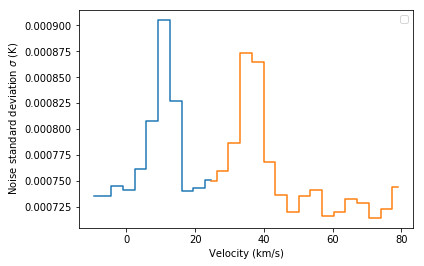

In [31]:
# Get noise map
mad_std_map_sclip_low = get_noise_map(subcube_low)
mad_std_map_sclip_high = get_noise_map(subcube_high)

In [32]:
plain_mask_low = subcube_low >= 3 * mad_std_map_sclip_low
plain_masked_slab_low = subcube_low.with_mask(plain_mask_low)
plain_mask_high = subcube_high >= 3 * mad_std_map_sclip_high
plain_masked_slab_high = subcube_high.with_mask(plain_mask_high)

In [33]:
signal_mask_low = get_signal_mask_scipy(plain_masked_slab_low, mad_std_map_sclip_low)
masked_cube_low = plain_masked_slab_low.with_mask(signal_mask_low)
signal_mask_high = get_signal_mask_scipy(plain_masked_slab_high, mad_std_map_sclip_high)
masked_cube_high = plain_masked_slab_high.with_mask(signal_mask_high)

Initial number of regions found: 9414
Final number of regions found: 2
Initial number of regions found: 9593
Final number of regions found: 2


In [34]:
# Let's get masked moment maps for each of the cubes
masked_moment0_low = masked_cube_low.moment0()
masked_moment0_high = masked_cube_high.moment0()
mom0s = [masked_moment0_low, masked_moment0_high]

/blue/adamginsburg/abulatek/anaconda/lib/python3.7/site-packages/radio_beam-0.3.3-py3.7.egg/radio_beam/multiple_beams.py:265: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/blue/adamginsburg/abulatek/anaconda/lib/python3.7/site-packages/radio_beam-0.3.3-py3.7.egg/radio_beam/multiple_beams.py:265: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"


In [35]:
collapse1_low = masked_cube_low.mean(axis = 1) # Collapse along one spatial axis
collapse2_low = masked_cube_low.mean(axis = 2) # Collapse along the other spatial axis
collapse1_high = masked_cube_high.mean(axis = 1) # Collapse along one spatial axis
collapse2_high = masked_cube_high.mean(axis = 2) # Collapse along the other spatial axis
collapse1s = [collapse1_low, collapse1_high]
collapse2s = [collapse2_low, collapse2_high]

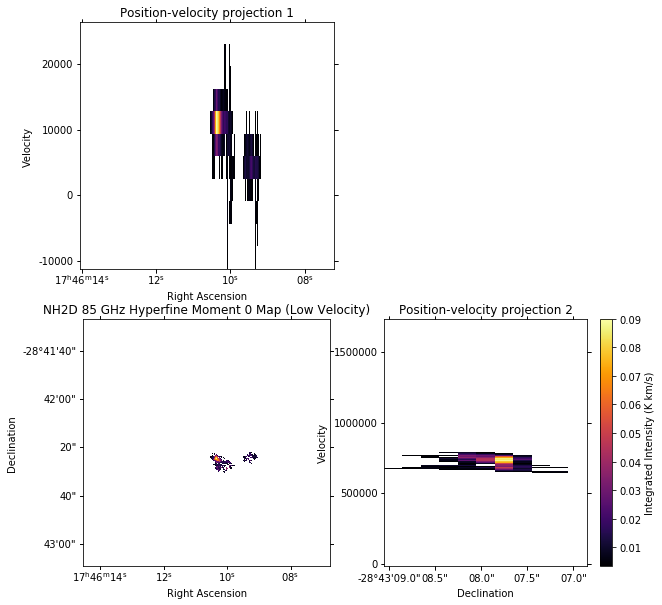

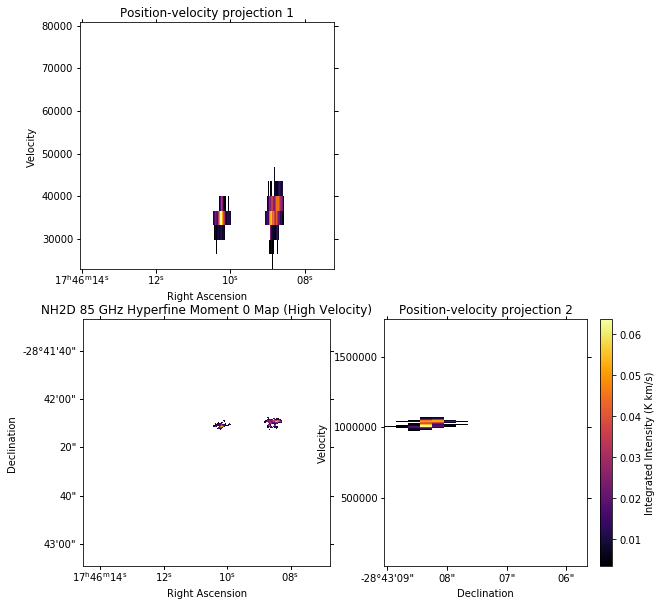

In [36]:
i = 0
for i in range(len(mom0s)):
    masked_moment0 = mom0s[i]
    collapse1 = collapse1s[i]
    collapse2 = collapse2s[i]
    if i == 0:
        plot_type = 'Low'
    elif i == 1:
        plot_type = 'High'
    
    # Initalize figure
    fig = plt.figure(1, figsize = (10, 10), tight_layout = False)

    # Plot moment 0 map
    ax = plt.subplot(223, projection = masked_moment0.wcs)
    im1 = ax.imshow(masked_moment0.value, origin='lower', cmap='inferno')
    ax.set_ylabel('Declination')
    ax.set_xlabel('Right Ascension')
    plt.title(f'NH2D 85 GHz Hyperfine Moment 0 Map ({plot_type} Velocity)')

    # Plot PV projection along one spatial axis
    ax = plt.subplot(221, projection = collapse1.wcs)
    im2 = ax.imshow(collapse1.value, origin='lower', cmap='inferno', aspect='auto')
    ax.set_ylabel('Velocity')
    ax.set_xlabel('Right Ascension')
    plt.title('Position-velocity projection 1')

    # Plot PV projection along the other spatial axis
    ax = plt.subplot(224, projection = collapse2.T.wcs)
    im3 = ax.imshow(collapse2.T.value, origin='lower', cmap='inferno', aspect='auto')
    ax.set_ylabel('Velocity')
    ax.set_xlabel('Declination')
    plt.title('Position-velocity projection 2')

    cbar = plt.colorbar(im1)
    cbar.set_label('Integrated Intensity (K km/s)')

    # plt.savefig(f'/blue/adamginsburg/abulatek/brick/first_results/lineID/plots/unlabeled/{freq_spw}.pdf')
    plt.show()
    i += 1